# Sampling

Here we show how to use `Texture` and its caveats.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import hephaistos as hp
from scipy import misc

assert hp.isVulkanAvailable(), "Vulkan is not supported!"
assert hp.isCompilerAvailable(), "No compiler available!"

print(f"Selected Device: {hp.getCurrentDevice().name}")

Selected Device: NVIDIA GeForce RTX 3060 Ti


## Sampling

Here we recreate the sampling example.

In [2]:
#scaling params
width = 1536
height = 1152

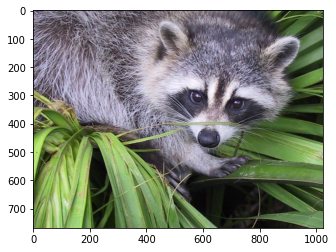

In [3]:
image = misc.face()
plt.imshow(image)
plt.show()

In [4]:
image.shape, image.dtype

((768, 1024, 3), dtype('uint8'))

We're missing an alpha channel, so we'll add it

In [5]:
image = np.concatenate((image, (np.ones_like(image[...,0]) * 255)[...,None]), axis=-1)
image.shape, image.dtype

((768, 1024, 4), dtype('uint8'))

In [6]:
bufferIn = hp.ByteBuffer(image.size)
np.copyto(bufferIn.numpy(), image.flatten())

texture = hp.Texture(hp.ImageFormat.R8G8B8A8_UNORM, image.shape[1], image.shape[0])
img = hp.Image(hp.ImageFormat.R8G8B8A8_UNORM, width, height)

bufferOut = hp.ByteBuffer(width * height * 4)

In [7]:
code = hp.compileFile("../examples/sampling/sampling.comp")
program = hp.Program(code)
program.bindParams(inImage=texture, outImage=img)

hp.beginSequence().And(hp.updateTexture(bufferIn, texture)).Then(program.dispatch(width, height)).Then(hp.retrieveImage(img, bufferOut)).Submit()

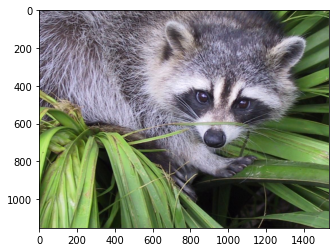

In [8]:
plt.imshow(bufferOut.numpy().reshape((height, width, 4)))
plt.show()

## Linear Interpolation Precision

Little known fact, but the hardware accelerate linear interpolation isn't a true linear interpolation, but rather a step function due to its limited precision (usually 8bit -> 256 steps) between elements.

In [9]:
steps = 1024

In [10]:
bufferIn = hp.FloatBuffer(2)
np.copyto(bufferIn.numpy(), np.array([-10, 10.0]))
textureIn = hp.Texture(hp.ImageFormat.R32_SFLOAT, 2, modeU="clamp edge")

bufferOut = hp.FloatBuffer(steps)
tensorOut = hp.FloatTensor(steps)

In [11]:
source = f"""
#version 460

layout(local_size_x = 1) in;

layout(binding = 0) writeonly buffer tensorOut {{ float value[]; }};
layout(binding = 1) uniform sampler1D inImage;

void main() {{
    float u = float(gl_GlobalInvocationID.x) / {steps}.0;
    //pixel are sampled at the center -> cut off edges
    u = (u / 2.0) + 0.25;
    value[gl_GlobalInvocationID.x] = texture(inImage, u).x;
}}
"""

code = hp.compileSource(source)
program = hp.Program(code)
program.bindParams(tensorOut=tensorOut, inImage=textureIn)

hp.beginSequence().And(hp.updateTexture(bufferIn, textureIn)).Then(program.dispatch(steps)).Then(hp.retrieveTensor(tensorOut, bufferOut)).Submit()

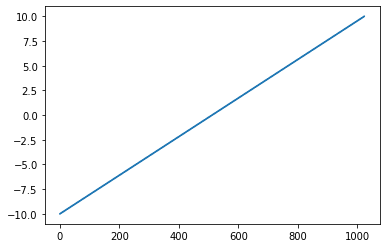

In [12]:
plt.figure()
plt.plot(np.arange(steps), bufferOut.numpy())
plt.show()

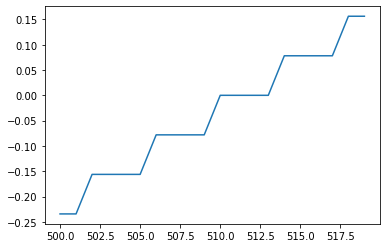

In [13]:
plt.figure()
plt.plot(np.arange(500,520),bufferOut.numpy()[500:520])
plt.show()